# 05 — Control System Response Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharathSPhD/RLpower/blob/main/notebooks/05_control_analysis.ipynb)

Interactive analysis of sCO₂ cycle controller performance using classical control metrics.

**Features:**
- Step response plots (W_net, T_comp, P_high) with annotated metrics
- Bode plots (gain/phase margin, bandwidth)
- Numerical metric tables (IAE, ITAE, settling time, overshoot)
- Cross-phase heatmap comparison
- Loads pre-computed JSON — **no FMU required** (Colab-compatible)

**Controller library:** `sco2rl.control` — IMC-tuned `MultiLoopPID` and `RLController`
**Analysis library:** `sco2rl.analysis` — `ScenarioRunner`, `StepResponseResult`, `FrequencyResponseResult`

In [1]:
# ── Environment Setup (runs on Colab or locally) ─────────────────────────────
import subprocess, sys, os

IN_COLAB = False
try:
    import google.colab  # noqa: F401
    IN_COLAB = True
except ImportError:
    pass

REPO_URL = 'https://github.com/SharathSPhD/RLpower.git'
BRANCH   = 'claude/control-systems-cloud-enhancements-bUVTD'

if IN_COLAB:
    if not os.path.exists('/content/RLpower'):
        subprocess.run(['git', 'clone', '--depth', '1', '-b', BRANCH,
                         REPO_URL, '/content/RLpower'], check=True)
    os.chdir('/content/RLpower')
    sys.path.insert(0, '/content/RLpower/src')
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-e', '.[control]',
                     '--quiet'], check=True)

from pathlib import Path
ROOT = Path('.').resolve()
if ROOT.name == 'notebooks':
    ROOT = ROOT.parent
if str(ROOT / 'src') not in sys.path:
    sys.path.insert(0, str(ROOT / 'src'))

import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Use inline backend
%matplotlib inline
plt.rcParams.update({
    'font.size': 10, 'axes.titlesize': 11,
    'axes.labelsize': 10, 'legend.fontsize': 9,
    'lines.linewidth': 1.5, 'axes.grid': True, 'grid.alpha': 0.3,
})
print('Setup complete. ROOT =', ROOT)

Setup complete. ROOT = /home/sharaths/projects/sco2rl


In [2]:
# ── Load pre-computed analysis results ───────────────────────────────────────
def _load_json(rel_path):
    p = ROOT / rel_path
    if not p.exists():
        raise FileNotFoundError(f'Data file not found: {p}\nRun: python scripts/run_control_analysis.py --use-mock')
    with open(p) as f:
        return json.load(f)

all_data  = _load_json('data/control_analysis_all_phases.json')
p0_data   = _load_json('data/control_analysis_phase0.json')

all_results = all_data['results']
p0_results  = p0_data['results']

print(f"Loaded {len(all_results)} result objects (generated by {all_data['generated_by']})")
print(f"Phases covered: {sorted(set(r['phase'] for r in all_results))}")
print(f"Scenarios: {sorted(set(r['scenario'] for r in all_results))}")

Loaded 28 result objects (generated by sco2rl.analysis.scenario_runner.ScenarioRunner)
Phases covered: [0, 1, 2, 3, 4, 5, 6]
Scenarios: ['frequency_response', 'load_rejection_-50pct', 'step_load_+20pct', 'step_load_-20pct']


In [3]:
# ── Utility helpers ───────────────────────────────────────────────────────────
PHASE_NAMES = {
    0: 'Phase 0 — Steady-State',
    1: 'Phase 1 — Gradual Load',
    2: 'Phase 2 — Ambient Disturbance',
    3: 'Phase 3 — EAF Transients',
    4: 'Phase 4 — Load Rejection',
    5: 'Phase 5 — Cold Startup',
    6: 'Phase 6 — Emergency Trip',
}

def find_result(results, phase, scenario_substr):
    for r in results:
        if r['phase'] == phase and scenario_substr in r['scenario']:
            return r
    return None

def metric_table(step_res, label):
    """Return dict of metrics for a step response result dict."""
    if step_res is None:
        return {'Controller': label, 'Overshoot (%)': '—', 'Settling Time (s)': '—',
                'Rise Time (s)': '—', 'IAE': '—', 'SSE': '—'}
    return {
        'Controller': label,
        'Overshoot (%)': f"{step_res.get('overshoot_pct', 0):.1f}",
        'Settling Time (s)': f"{step_res.get('settling_time_s', 0):.0f}",
        'Rise Time (s)': f"{step_res.get('rise_time_s', 0):.0f}",
        'IAE': f"{step_res.get('iae', 0):.2f}",
        'SSE': f"{step_res.get('steady_state_error', 0):.3f}",
    }

print('Helpers defined.')

Helpers defined.


## Interactive Scenario Selector

Use the widgets below to select a curriculum phase, scenario, and metric.
The plots update automatically.
> **Tip:** If `ipywidgets` is not installed, skip to Section 3 and run the cells directly.

In [4]:
# ── Interactive widgets (ipywidgets) ─────────────────────────────────────────
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print('ipywidgets not installed. Install with: pip install ipywidgets')
    print('Running static plots instead.')

if HAS_WIDGETS:
    phase_dd = widgets.Dropdown(
        options=[(PHASE_NAMES[p], p) for p in sorted(PHASE_NAMES)],
        value=0, description='Phase:', style={'description_width': 'initial'}
    )
    scenario_dd = widgets.Dropdown(
        options=['+20% Load Step', '-20% Load Step', '-50% Load Rejection'],
        value='+20% Load Step', description='Scenario:',
        style={'description_width': 'initial'}
    )
    out = widgets.Output()

    SCENARIO_MAP = {
        '+20% Load Step': '+20',
        '-20% Load Step': '-20',
        '-50% Load Rejection': 'rejection',
    }

    def _on_change(change):
        with out:
            clear_output(wait=True)
            phase  = phase_dd.value
            sc_key = SCENARIO_MAP[scenario_dd.value]
            r = find_result(all_results, phase, sc_key)
            if r is None:
                print(f'No result for Phase {phase} / {scenario_dd.value}')
                return
            _plot_step_response(r, phase, scenario_dd.value)

    phase_dd.observe(_on_change, names='value')
    scenario_dd.observe(_on_change, names='value')

    display(widgets.VBox([
        widgets.HBox([phase_dd, scenario_dd]),
        out
    ]))
    _on_change(None)

## Section 2: Step Response Analysis
Phase 0, +20% load step — PID controller

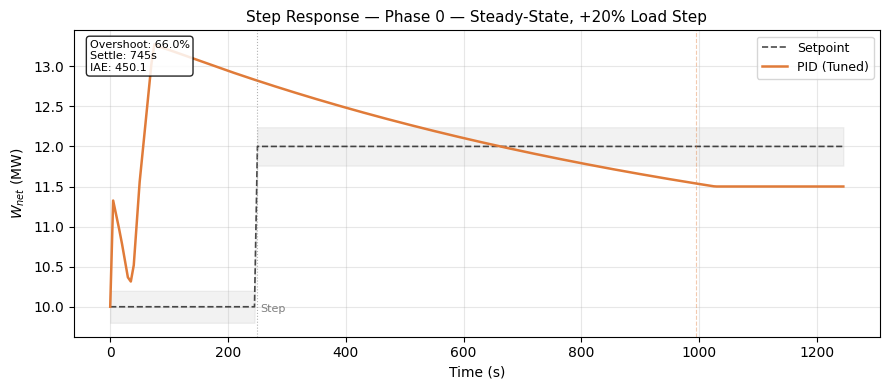

In [5]:
# ── Step response plot function ───────────────────────────────────────────────
def _plot_step_response(r, phase, scenario_label):
    pid = r.get('pid_step')
    rl  = r.get('rl_step')

    if pid is None and rl is None:
        print('No step response data available for this selection.')
        return

    fig, ax = plt.subplots(figsize=(9, 4))

    if pid is not None and pid.get('time_s'):
        t  = np.array(pid['time_s'])
        sp = np.array(pid['setpoint'])
        resp = np.array(pid['response'])
        onset = pid.get('step_onset_s', 0)

        ax.plot(t, sp, 'k--', lw=1.2, alpha=0.7, label='Setpoint')
        ax.fill_between(t, sp*0.98, sp*1.02, alpha=0.1, color='gray')
        ax.plot(t, resp, color='#e07b39', lw=1.8, label='PID (Tuned)')
        ax.axvline(onset, color='gray', lw=0.8, ls=':', alpha=0.6)
        ax.text(onset + 5, ax.get_ylim()[0] + 0.08*(ax.get_ylim()[1]-ax.get_ylim()[0]),
                'Step', fontsize=8, color='gray')

        ts = pid.get('settling_time_s', 0)
        ov = pid.get('overshoot_pct', 0)
        iae = pid.get('iae', 0)
        if ts > 0:
            ax.axvline(onset + ts, color='#e07b39', lw=0.8, ls='--', alpha=0.4)
        info = f'Overshoot: {ov:.1f}%\nSettle: {ts:.0f}s\nIAE: {iae:.1f}'
        ax.text(0.02, 0.97, info, transform=ax.transAxes, va='top', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.85))

    if rl is not None and rl.get('time_s'):
        t_rl = np.array(rl['time_s'])
        ax.plot(t_rl, np.array(rl['response']), color='steelblue', lw=1.8, label='RL')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('$W_{net}$ (MW)')
    ax.set_title(f'Step Response — {PHASE_NAMES.get(phase, f"Phase {phase}")}, {scenario_label}')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Static plot for Phase 0 +20%
r0 = find_result(all_results, 0, '+20')
if r0:
    _plot_step_response(r0, 0, '+20% Load Step')

## Section 3: Numerical Metrics Table

In [6]:
# ── Metrics table for Phase 0 ─────────────────────────────────────────────────
try:
    import pandas as pd
    HAS_PANDAS = True
except ImportError:
    HAS_PANDAS = False

r0 = find_result(all_results, 0, '+20')
rows = []
if r0:
    rows.append(metric_table(r0.get('pid_step'), 'PID (Tuned)'))
    rows.append(metric_table(r0.get('rl_step'),  'RL Policy'))

if HAS_PANDAS and rows:
    import pandas as pd
    df = pd.DataFrame(rows).set_index('Controller')
    display(df.style.set_caption('Step Response Metrics — Phase 0, +20% Load Step'))
else:
    for row in rows:
        print(row)

,Overshoot (%),Settling Time (s),Rise Time (s),IAE,SSE
Controller,,,,,
PID (Tuned),66.0,745,995,450.15,-0.500
RL Policy,—,—,—,—,—


## Section 4: Frequency Response (Bode Plot)
Bypass valve → W_net channel, Phase 0

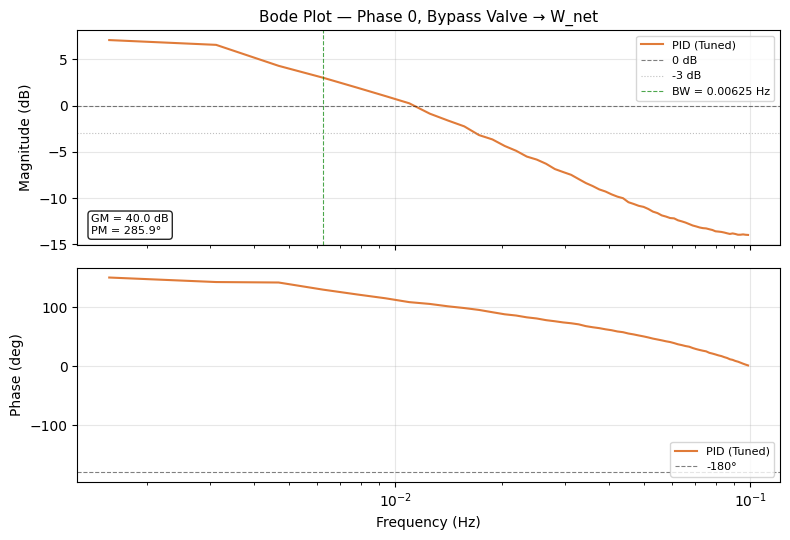


Metric                        PID (Tuned)     Target
----------------------------------------------------
Gain Margin (dB)                     40.0        ≥ 6
Phase Margin (deg)                  285.9       ≥ 45
Bandwidth (Hz)                    0.00625          —


In [7]:
# ── Bode plot from pre-computed frequency response data ───────────────────────
r_freq = find_result(all_results, 0, 'freq')
if r_freq is None:
    r_freq = find_result(p0_results, 0, 'freq')

if r_freq and r_freq.get('pid_freq'):
    pf = r_freq['pid_freq']
    freqs  = np.array(pf['frequencies_hz'])
    mag_db = np.array(pf['magnitude_db'])
    ph_deg = np.array(pf['phase_deg'])
    gm  = pf.get('gain_margin_db', float('nan'))
    pm  = pf.get('phase_margin_deg', float('nan'))
    bw  = pf.get('bandwidth_hz', float('nan'))

    fig, axes = plt.subplots(2, 1, figsize=(8, 5.5), sharex=True)

    axes[0].semilogx(freqs, mag_db, color='#e07b39', label='PID (Tuned)')
    axes[0].axhline(0,  color='k',    lw=0.8, ls='--', alpha=0.5, label='0 dB')
    axes[0].axhline(-3, color='gray', lw=0.8, ls=':', alpha=0.5, label='-3 dB')
    if not np.isnan(bw):
        axes[0].axvline(bw, color='green', lw=0.8, ls='--', alpha=0.7,
                        label=f'BW = {bw:.5f} Hz')
    axes[0].set_ylabel('Magnitude (dB)')
    axes[0].set_title('Bode Plot — Phase 0, Bypass Valve → W_net')
    axes[0].legend(fontsize=8, loc='upper right')
    axes[0].text(0.02, 0.05,
                 f'GM = {gm:.1f} dB\nPM = {pm:.1f}°',
                 transform=axes[0].transAxes, fontsize=8,
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.85))

    axes[1].semilogx(freqs, ph_deg, color='#e07b39', label='PID (Tuned)')
    axes[1].axhline(-180, color='k', lw=0.8, ls='--', alpha=0.5, label='-180°')
    axes[1].set_ylabel('Phase (deg)')
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].legend(fontsize=8, loc='lower right')

    plt.tight_layout()
    plt.show()

    # Stability margin table
    print(f'\n{"Metric":<25} {"PID (Tuned)":>15} {"Target":>10}')
    print('-' * 52)
    print(f'{"Gain Margin (dB)":<25} {gm:>15.1f} {"≥ 6":>10}')
    print(f'{"Phase Margin (deg)":<25} {pm:>15.1f} {"≥ 45":>10}')
    print(f'{"Bandwidth (Hz)":<25} {bw:>15.5f} {"—":>10}')
else:
    print('No frequency response data available.')
    print('Run: python scripts/run_control_analysis.py --use-mock --phases 0')

## Section 5: All-Phase Comparison Heatmap

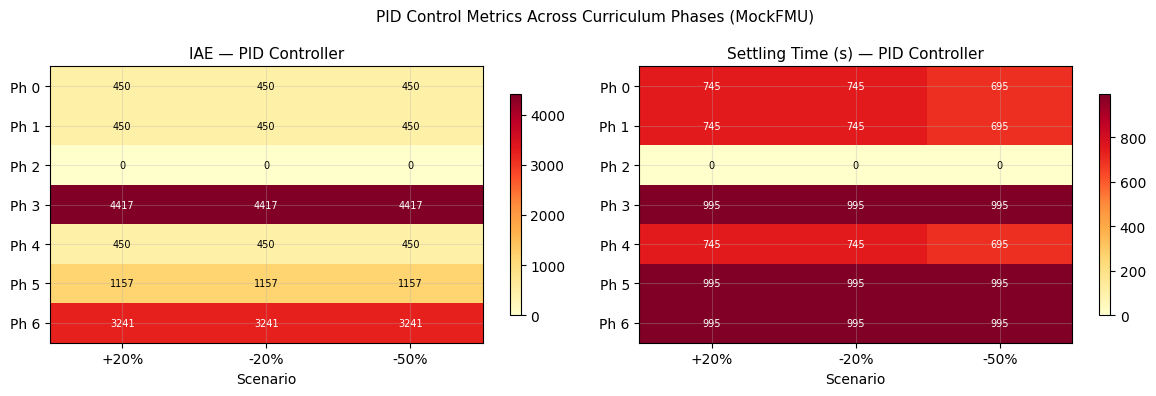

In [8]:
# ── Control metrics heatmap across all curriculum phases ──────────────────────
phases    = list(range(7))
scenarios = ['step_load_+20pct', 'step_load_-20pct', 'load_rejection_-50pct']
sc_labels = ['+20%', '-20%', '-50%']

iae_mat    = np.full((len(phases), len(scenarios)), np.nan)
settle_mat = np.full((len(phases), len(scenarios)), np.nan)

for r in all_results:
    ph = r['phase']
    sc = r['scenario']
    if r.get('pid_step') and ph < len(phases):
        for j, s in enumerate(scenarios):
            if s == sc:
                iae_mat[ph, j]    = r['pid_step']['iae']
                settle_mat[ph, j] = r['pid_step']['settling_time_s']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ph_labels = [f'Ph {p}' for p in phases]

for ax, mat, title in [
    (axes[0], iae_mat,    'IAE — PID Controller'),
    (axes[1], settle_mat, 'Settling Time (s) — PID Controller'),
]:
    plot_mat = np.where(np.isnan(mat), 0, mat)
    im = ax.imshow(plot_mat, aspect='auto', cmap='YlOrRd')
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels(sc_labels)
    ax.set_yticks(range(len(phases)))
    ax.set_yticklabels(ph_labels)
    ax.set_title(title)
    ax.set_xlabel('Scenario')
    plt.colorbar(im, ax=ax, shrink=0.8)
    mx = plot_mat.max() if plot_mat.max() > 0 else 1
    for i in range(len(phases)):
        for j in range(len(scenarios)):
            val = mat[i, j]
            if not np.isnan(val):
                c = 'white' if plot_mat[i, j] > 0.6 * mx else 'black'
                ax.text(j, i, f'{val:.0f}', ha='center', va='center',
                        fontsize=7, color=c)

fig.suptitle('PID Control Metrics Across Curriculum Phases (MockFMU)', fontsize=11)
plt.tight_layout()
plt.show()

## Section 6: Live Analysis (requires sco2rl installed)
Run a live step-response analysis using the MockFMU environment.

Running live step-response analysis with MockFMU...
Live run complete: Phase 0, step_load_+20pct
  Overshoot: 66.0%
  Settling:  745s
  IAE:       450.15


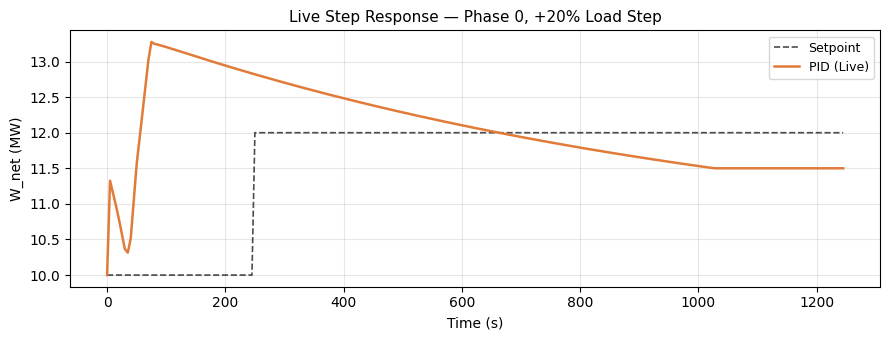

In [9]:
# ── Live analysis with MockFMU ────────────────────────────────────────────────
try:
    from sco2rl.analysis.scenario_runner import ScenarioRunner, ControlScenario, build_mock_env, build_mock_pid

    print('Running live step-response analysis with MockFMU...')
    pid = build_mock_pid()
    runner = ScenarioRunner(n_seeds=1, dt=5.0, verbose=False)
    live_results = runner.run_all(
        env_factory=build_mock_env,
        pid_policy=pid,
        rl_policy=None,
        phases=[0],
        scenarios=[ControlScenario.STEP_LOAD_UP_20],
        run_frequency=False,
    )
    r_live = live_results[0]
    print(f'Live run complete: Phase {r_live.phase}, {r_live.scenario}')
    if r_live.pid_step:
        ps = r_live.pid_step
        print(f'  Overshoot: {ps.overshoot_pct:.1f}%')
        print(f'  Settling:  {ps.settling_time_s:.0f}s')
        print(f'  IAE:       {ps.iae:.2f}')

        fig, ax = plt.subplots(figsize=(9, 3.5))
        ax.plot(ps.time_s, ps.setpoint, 'k--', lw=1.2, alpha=0.7, label='Setpoint')
        ax.plot(ps.time_s, ps.response, '#e07b39', lw=1.8, label='PID (Live)')
        ax.set_xlabel('Time (s)'); ax.set_ylabel('W_net (MW)')
        ax.set_title('Live Step Response — Phase 0, +20% Load Step')
        ax.legend(); plt.tight_layout(); plt.show()

except Exception as e:
    print(f'Live analysis unavailable: {e}')
    print('Using pre-computed data instead (see Section 2).')

## Section 7: SCOPE Controller Library Usage
Demo of the reusable `sco2rl.control` API

In [10]:
# ── Public API demo ───────────────────────────────────────────────────────────
from sco2rl.control import Controller, PIDController, MultiLoopPID
from sco2rl.analysis import ScenarioRunner, ControlScenario
from sco2rl.analysis.scenario_runner import build_mock_pid, build_mock_env
import numpy as np

# Single-channel PID
pid_single = PIDController(
    kp=0.25, ki=0.010, kd=0.50,
    setpoint=10.0,            # W_net setpoint (MW)
    output_limits=(-1.0, 1.0),
    anti_windup_gain=0.1,
    derivative_filter_tau=10.0,
    dt=5.0,
)

# Simulate 10 steps at design point (W_net ≈ 10.0 MW)
w_net = 10.0
actions = []
for step in range(10):
    action = pid_single.compute(w_net)
    actions.append(action)
    w_net += 0.05 * action   # simplified dynamics

print('PIDController demo:')
print(f'  Actions: {[f"{a:.4f}" for a in actions]}')

# MultiLoopPID (4-channel) — uses MockFMU config
multi_pid = build_mock_pid()
print(f'\nMultiLoopPID: {multi_pid.name}')

# Show Controller interface is compatible with SB3 predict()
obs = np.zeros(50, dtype=np.float32)  # 10 obs × 5 history steps
obs[7] = 0.5   # W_net normalised offset
action, _ = multi_pid.predict(obs)
print(f'\npredict() action shape: {action.shape}, dtype: {action.dtype}')

print('\n✓ sco2rl.control API works correctly.')

PIDController demo:
  Actions: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']

MultiLoopPID: MultiLoopPID

predict() action shape: (4,), dtype: float32

✓ sco2rl.control API works correctly.
